# Epsilon Greedy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Base

In [2]:
data = pd.read_csv('../Data/dataset_1000_minimum_reviews.csv', index_col='Unnamed: 0')
data.head()

,user_id,movie_id,rating,genre,age,time,binary_rating
0,1107,1961,5,Drama,50,0,1
1,1545,1259,3,Adventure|Comedy|Drama,25,1,0
2,3304,595,5,Animation|Children's|Musical,45,2,1
3,5448,260,4,Action|Adventure|Fantasy|Sci-Fi,45,3,0
4,3829,1784,2,Comedy|Drama,25,4,0


In our case, only 4 features are useful : "time", "movie_id", "user_id" and "binary_rating".

In [3]:
df = data[['time', 'movie_id', 'user_id', 'binary_rating']]
df.head()

,time,movie_id,user_id,binary_rating
0,0,1961,1107,1
1,1,1259,1545,0
2,2,595,3304,1
3,3,260,5448,0
4,4,1784,3829,0


In [4]:
arms = pd.DataFrame(df.groupby('movie_id'))[0].tolist() #We extract the list of movie_id which is our arms
arms[0:5]

[1, 11, 21, 32, 34]

## Epsilon Greedy Algorithm

We will first define our Algorithm of interest, the principle is simple, we either select the arm with the highest empirical mean with probability epsilon, or we select a random arm with probability epsilon. In our case, the arms are the movies to recommend to the users.

### Algorithm

In [5]:
def epsilon_greedy_algorithm (df, arms, epsilon, n_recommendations):
    
    #First, we have to chose if which arms we are going for, we will use a bernoulli :
    selector = np.random.binomial(1, epsilon)
    
    #With that, il selector == 1 (or for our initialisation == the dataframe is still empty), 
    #it means that we are going to chose random arms :
    if selector == 1 or df.shape[0]==0:
        recommendations = np.random.choice(a = arms, size = n_recommendations, replace = False)
        
    #Otherwise, we need to go for the arms with the highest empirical means :
    else:
        emp_mean = df.groupby('movie_id').agg({'binary_rating': ['mean']}) #We compute the empirical mean for each movie
        emp_mean = emp_mean['binary_rating'].sort_values(by = 'mean', ascending = False) #We sort the DataFrame
        recommendations = emp_mean.iloc[:n_recommendations].index.tolist() #We get our movie_id with the highest mean
        
    return recommendations
        

We can then print a few iterations to verify that we indeed have randomness in our recommendations (we chose epsilon high for more cases where the output is random).

In [6]:
for i in range(5):
    print(epsilon_greedy_algorithm (df, arms, epsilon=0.4, n_recommendations=5))

[858, 318, 50, 527, 260]
[1387 3160 1196 3623 1608]
[ 593 1208   47 1094 1396]
[858, 318, 50, 527, 260]
[ 923  377 1673 3418 3361]


### Reward Function

The principle is simple, we will tell our epsilon greedy algorithm if it guessed good recommendations. Good recommendations mean that people gave a score of 5 to the movies that are recommended.

When our algorithm guesses right, we reward it by giving it a point that we will add to a list of rewards, else, we give it a score of 0 that we also append to the same list of rewards.

In [7]:
def reward_function (df, recommendations, time, sample_size):
    
    #recommendations : it is the output of the previous function 'epsilon_greedy_algorithm'
    #time : it is akin to a time indicator, we use it to keep track of where we are rendered it the DataFrame,
    
    #Our goal is to compare our recommendations to what the users acutally liked at the dates : 
    #date1 = time and date2 = time + sample_size
    
    #So first, we need to know which movies were watched in our timeframe study, so we isolate them
    iteration_df = df.iloc[time : time+sample_size]
    #Then, we can isolate the movies in our "iteration_df" that were recommended 
    df_cross_recommendations = iteration_df[iteration_df['movie_id'].isin(recommendations)]
    #Finally, we get the list of binary_rating corresponding to these movies
    rewards = df_cross_recommendations['binary_rating'].tolist()
    #Note that our last variable exactly correspond to our rewards
    
    return rewards

## Application

We can now define our loop to see the performances of our algorithm on our data.

### Variables

In [8]:
epsilon = 0.1
n_recommendations = 5 #Here is the number of arms that we are going to recommend at each iteration
sample_size = 50 #We define the size of each sample, these samples will be used to determine in hindsight 
                 #if our recommendations were correct or not


### Algorithm

In [9]:
def compute_rewards (df, arms, epsilon, n_recommendations, sample_size):
    
    rewards = [] #We will gather our reward data to analyse the accuracy of our algorithm
    
    for i in range(df.shape[0]//sample_size):
        
        time = i*sample_size #We first get the time
        past_data = df.iloc[:time] #We then gather all our past data on which we will apply our epsilon greedy algorithm
        
        #We then apply our epsilon_greedy_algorithm to get our recommendations
        recommendations = epsilon_greedy_algorithm (past_data, arms, epsilon, n_recommendations)
        
        #we then end by simply collecting our rewards
        rewards.extend(reward_function (df, recommendations, time, sample_size))
    
    return rewards
    

In [10]:
rewards = compute_rewards (df, arms, epsilon, n_recommendations, sample_size)
print(rewards)


[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 

## Plots

We will plot the cumulative average of our rewards list. That type of graph also allows us to see if the increasing size of the "past_data" does improve the performance of our algorithm.

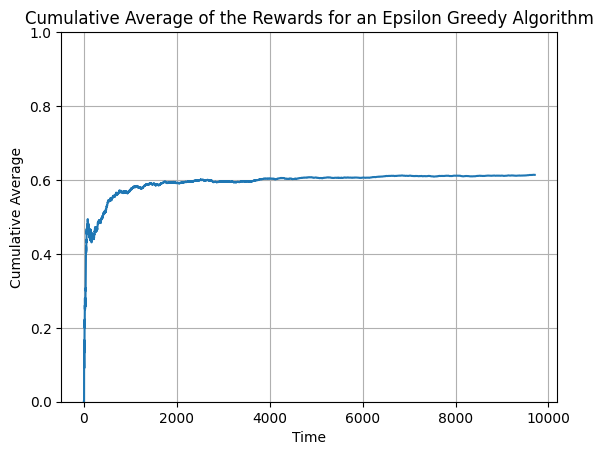

In [11]:
cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the Rewards for an Epsilon Greedy Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()
